In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from bsb import Scaffold, parse_configuration_file
from scipy.signal import welch, find_peaks
import pandas as pd
from IPython.display import HTML, display
from utils import extract_device_data, plot_signal

In [2]:
# bsb.options.verbosity = 3
config = parse_configuration_file("configurations/io.yaml", parser="yaml")

scaffold = Scaffold(config)
scaffold.compile(clear=True)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jul 13 2025 01:06:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Sep 15 11:40:20 Install [Info]: 
    loaded module iomodule
[2025-09-15 11:40:20.369906 - BSB] JobStatus.RUNNING {root}.placement.io_layer_placement
[2025-09-15 11:40:20.380289 - BSB] JobStatus.SUCCESS {root}.placement.io_layer_placement
[2025-09-15 11:40:20.385798 - BSB] JobStatus.RUNNING {root}.connectivity.gap_io
[2025-09-15 11:40:20.393802 - BSB] JobStatus.SUCCESS {root}.connectivity.gap_io


In [3]:
storage = scaffold.storage

for cell_name, cell_type in scaffold.cell_types.items():
    ps = cell_type.get_placement_set() 
    pos = ps.load_positions()
    print(f"{len(pos)} {cell_name} placed")

5 io placed


In [4]:
cs = scaffold.get_connectivity_set("gap_io")
for pre_locs, post_locs in cs.load_connections():
    pre_cell_id = pre_locs[0]
    post_cell_id = post_locs[0]

    print(f"Gap junction between cell {pre_cell_id} and {post_cell_id}")

In [5]:
results = scaffold.run_simulation("basal_activity")
spiketrains = results.spiketrains
signals = results.analogsignals


Sep 15 11:40:20 Install [Info]: 
    loaded module iomodule
gap_io: 100%|██████████| 1/1 [00:00<00:00, 148.17it/s]


/home/niccolo/Projects/Neuro/cereb_env/lib/python3.10/site-packages/nest/lib/hl_api_helper.py:114: UserWarning:
Models is deprecated and will be removed in a future version of NEST.
Please use nest.node_models or nest.synapse_models instead!


In [6]:
# Extract device data
devices_data = extract_device_data(config)

# Create a DataFrame for better display
devices_df = pd.DataFrame(devices_data)
HTML(devices_df.to_html(index=False))


name,type,device,start,stop,weight,amplitude
background_noise,DCGenerator,dc_generator,500.0,550.0,1.0,20.0
io_record,SpikeRecorder,spike_recorder,NaN,NaN,1.0,NaN
io_Vm_record,Multimeter,multimeter,NaN,NaN,1.0,NaN


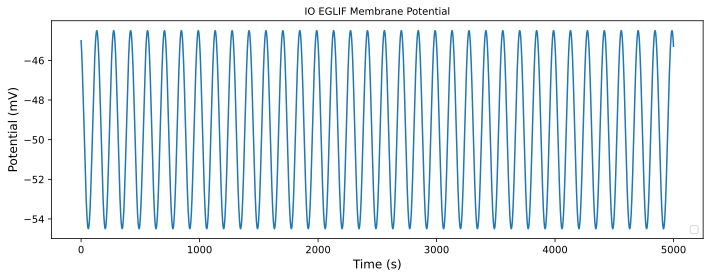

In [7]:
# Analyze signal without input
plot_signal(signal=signals[0], title="IO EGLIF Membrane Potential")

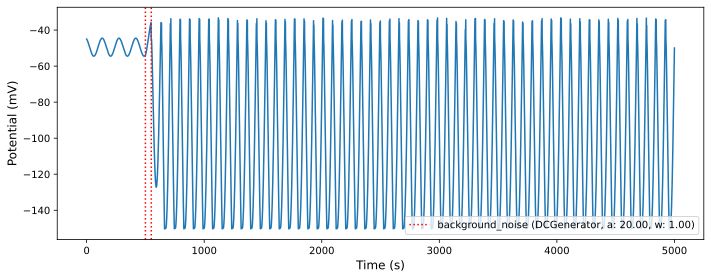

In [8]:
# Analyze signal with input
plot_signal(signal=signals[1], devices=devices_data)

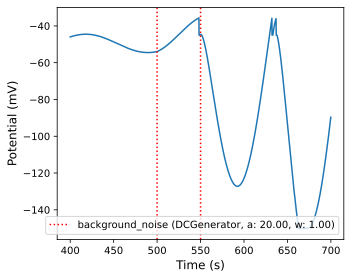

In [9]:
# Analyze input region
plot_signal(signal=signals[1], devices=devices_data, start=400, stop=700, figsize=(5, 4))

In [10]:
# Store results in lists
results = []

for i, vm_signal in enumerate(signals):
    sampling_rate = vm_signal.sampling_rate.rescale('Hz').magnitude
    v_m = vm_signal.magnitude.flatten()

    # Compute power spectral density
    frequencies, power = welch(v_m, fs=sampling_rate, nperseg=2048)

    # Focus on STO frequency range (1–100 Hz)
    sto_band = (frequencies >= 1) & (frequencies <= 100)
    sto_freq = frequencies[sto_band][np.argmax(power[sto_band])]

    # Find peaks and troughs
    peaks, _ = find_peaks(v_m)
    troughs, _ = find_peaks(-v_m)

    # Make sure we align peaks/troughs
    min_len = min(len(peaks), len(troughs))
    amplitudes = np.abs(v_m[peaks[:min_len]] - v_m[troughs[:min_len]])
    mean_amp = np.mean(amplitudes)
    
    # Store results
    results.append({
        "Signal ID": i,
        "STO Frequency (Hz)": round(sto_freq, 2),
        "Mean STO Amplitude (mV)": round(mean_amp, 2),
        "Peak Count": len(peaks),
        "Trough Count": len(troughs)
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Display as formatted table
print("IO Cell Analysis")
print("=" * 50)
HTML(results_df.to_html(index=False))

IO Cell Analysis


Signal ID,STO Frequency (Hz),Mean STO Amplitude (mV),Peak Count,Trough Count
0,4.88,9.99,35,35
1,14.65,60.36,113,114
2,4.88,9.99,35,35
3,4.88,9.99,35,35
4,4.88,9.99,35,35
